Confusion Matrix:
[[990  21]
 [ 13 314]]
Prediction accuracy is 0.97

Classification Report (Test Set):
              precision    recall  f1-score   support

  Legitimate       0.99      0.98      0.98      1011
      Jammed       0.94      0.96      0.95       327

    accuracy                           0.97      1338
   macro avg       0.96      0.97      0.97      1338
weighted avg       0.97      0.97      0.97      1338



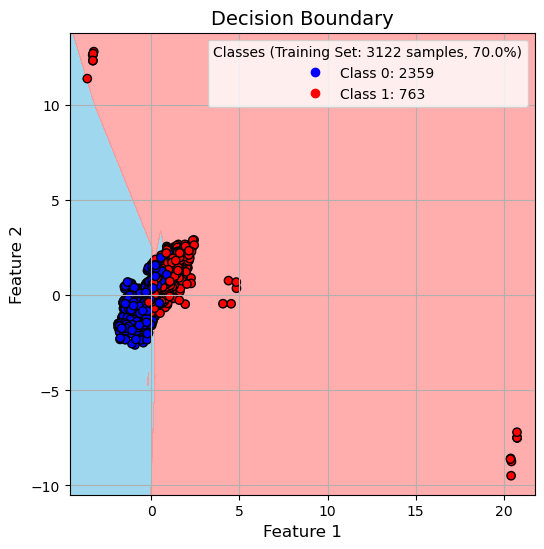

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the dataset
data_path = "../data/preprocessed_gnss_data.csv"
df = pd.read_csv(data_path, sep=";")

# Select numeric columns and the target column
numeric_columns = ['AGC', 'SNR', 'latitude', 'longitude', 'height', 'num_satellites']
X = df[numeric_columns]
y = df['class'].map({'legitimate': 0, 'jammed': 1})  # Convert target to binary

# Handle missing values by filling with mean
X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Calculate dataset sizes
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Create a multilayer perceptron classifier with 10 and 6 perceptrons in the hidden layers
predictor = MLPClassifier(hidden_layer_sizes=(10, 6), max_iter=1000, random_state=42)
predictor.fit(X_train, y_train)

# Predict classes
y_pred = predictor.predict(X_test)

# Assess the accuracy of the classifier
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

# Confusion Matrix with Percentages
M = confusion_matrix(y_test, y_pred)

# Add counts and percentages to confusion matrix annotations
M_counts = np.array([[f"{value}\n({value / sum(row) * 100:.1f}%)" for value in row] for row in M], dtype=object)

# Assess the accuracy of the classifier
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
M = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(M)
print(f"Prediction accuracy is {accuracy:.2f}")





# Print classification report
print("\nClassification Report (Test Set):")
report = classification_report(y_test, y_pred, target_names=["Legitimate", "Jammed"])
print(report)

# Reduce to 2D using PCA for decision boundary visualization
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train)
predictor_2D = MLPClassifier(hidden_layer_sizes=(10, 6), max_iter=1000, random_state=42)
predictor_2D.fit(X_train_2D, y_train)

# Plot decision boundaries
def plotDB(predictor, X, y, train_size, test_size, train_percentage, test_percentage, figsize=(6, 6)):
    if X.shape[1] != 2:
        raise ValueError("Can only plot decision boundaries for data with two features.")
    
    # Generate the grid for decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Flatten the grid for predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = predictor.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Define color maps
    cmap_background = ListedColormap(['#87CEEB', '#FF9999'])  # Light blue and red for decision regions
    cmap_points = ListedColormap(['blue', 'red'])             # Blue and red for data points
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_background)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap_points)

    # Add a legend with class names and counts (training set)
    unique_classes, class_counts = np.unique(y, return_counts=True)
    legend_labels = [f"Class {int(cls)}: {count}" for cls, count in zip(unique_classes, class_counts)]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title=f"Classes (Training Set: {train_size} samples, {train_percentage:.1f}%)", loc='upper right')

    # Add titles and labels
    plt.title('Decision Boundary', fontsize=14)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.grid(True)
    plt.show()

# Plot the decision boundary
plotDB(predictor_2D, X_train_2D, y_train.values, train_size, test_size, train_percentage, test_percentage, figsize=(6, 6))


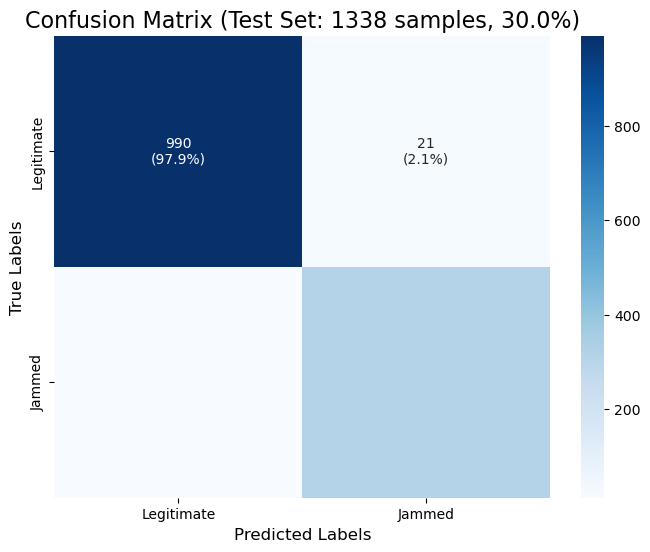

In [2]:
# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(M, annot=M_counts, fmt="", cmap="Blues", xticklabels=["Legitimate", "Jammed"], yticklabels=["Legitimate", "Jammed"])
plt.title(f"Confusion Matrix (Test Set: {test_size} samples, {test_percentage:.1f}%)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()
